In [1]:
%matplotlib notebook                      
import numpy as np                        # working with arrays
import imageio                            # reading images as an array
import matplotlib.pyplot as plt           # working with plots

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

from skimage import transform as tf
from mpl_toolkits.axes_grid1 import make_axes_locatable

#plt.style.use('~/jupyter-notebook/trial.mplstyle')

In [2]:
import warnings

Xmin = -180             # reactor boundaries
Xmax = +180
Ymin = -180
Ymax = +180

Xsize = Xmax-Xmin       # size of the X_Y grid
Ysize = Ymax-Ymin    
dx  = 1                 # space step in nm
dy  = dx                # dx = 8.5 nm

nX  = int(Xsize/dx)     # integer
nY  = int(Ysize/dy)

T  = 10000              # total time
dt = 1                  # time step
nt = int(T/dt)          # number of iterations

f      = 0.073          # equilibrium rate constant  
k_sol  = 0.135          # solidification rate

I_cr = 5.5              # quenching parameters
h = 50

delta = 2.04
Ds1i = 0.112            # diffusion constants 
Ds2i = Ds1i/delta
Di   = 0.17

CFLx = Di*dt/(dx**2)    # CFL satbility criterion

mag_facf = 105
mf=mag_facf
Xm,XM,Ym,YM =(Xmin/dx)/mf,(Xmax/dx)/mf,(Ymax/dx)/mf,(Ymin/dx)/mf
ds0 = 1

if (CFLx > 0.24 ) : warnings.warn("\n  CFL* HAS BEEN REACHED: CFL={:.3f}".format(CFLx))

print('Grid size (rows):...................{}'.format(nY))
print('Estimated simulation time (min):....{:.2f}'.format((4.5e-4*nX+5.12e-3)**2.3*T/dt/60)) # empirical func.
print('CFL (CFL*=0.16):....................{:.3f}'.format(CFLx))

Grid size (rows):...................360
Estimated simulation time (min):....2.72
CFL (CFL*=0.16):....................0.170


In [3]:
import BranchDiatom as brd

S1I,S2I = brd.get_initial_seed('seed_distorted.png',0.4,dx,nX,nY) # Vmax=0.4

<IPython.core.display.Javascript object>


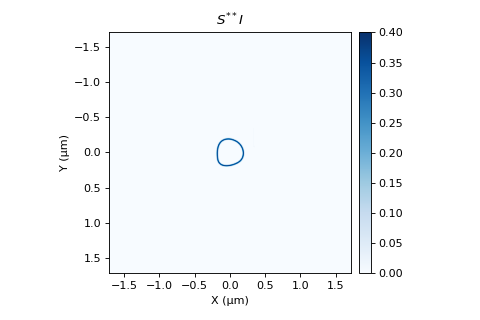

In [4]:
fig, ax = plt.subplots(figsize = (6,4),dpi=100)

physical_boundaries = [Xm,XM,Ym,YM] # in um

ax = plt.subplot(111)
ax.set_title(r'$S^{**}I$')
im1 = ax.imshow(S2I, cmap='Blues',extent =physical_boundaries)

ax.set_xlabel('X (μm)')
ax.set_ylabel('Y (μm)')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.10)
clb = fig.colorbar(im1, cax=cax, orientation='vertical')
plt.tight_layout()

#import get_valve_morphology as gvm

In [5]:
from tqdm.notebook import tqdm
ki = 0.0003

T = 4000#8000
n = int(T/dt)  

S1I,S2I = brd.get_initial_seed('seed_distorted.png',0.4,dx,nX,nY) # Vmax=0.4
S3 = np.zeros(np.shape(S1I))
I  = np.zeros(np.shape(S1I)) 
uni = np.ones(np.shape(S1I))
sol = 1*np.ones(np.shape(S1I))

sigma = 1
vel_est_025 =[]

for i in tqdm(range(n)):      
    
    deltaS1I = Ds1i*brd.laplacian(S1I,dx)
    deltaS2I = Ds2i*brd.laplacian(S2I,dx)
    deltaI   = Di*brd.laplacian(I,dx)

    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = brd.hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    #delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    #sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0-ki*I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)
    
    vel_est_025.append(np.sum(1*(I>0.25)[nY//2,:])/2)

    # Neumans b.c. 
    for Z in (S1I, S2I, S3, I):
        Z[0, :] = Z[1, :]
        Z[-1, :] = Z[-2, :]
        Z[:, 0] = Z[:, 1]
        Z[:, -1] = Z[:, -2]
        
#os.system('play -nq -t alsa synth {} sine {}'.format(0.5, 350))

  0%|          | 0/4000 [00:00<?, ?it/s]

NameError: name 'os' is not defined

<IPython.core.display.Javascript object>


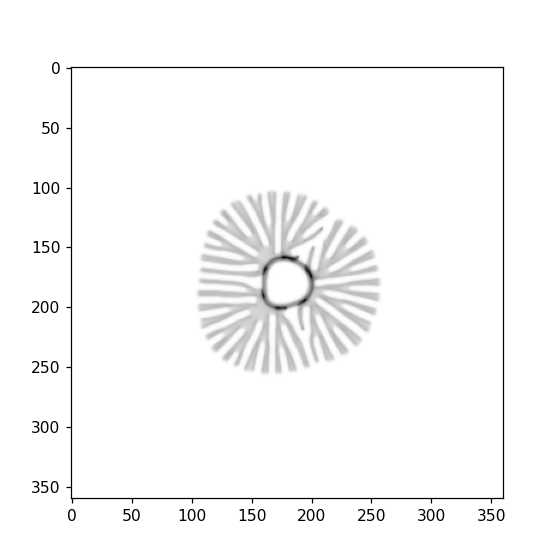

In [6]:
fig, ax = plt.subplots(figsize=(5,5),dpi=140)
ax = plt.subplot(111)

im = ax.imshow(S3,cmap='Greys')

#ax.axis('off')
#np.save('S3_pattern',S3)

<IPython.core.display.Javascript object>


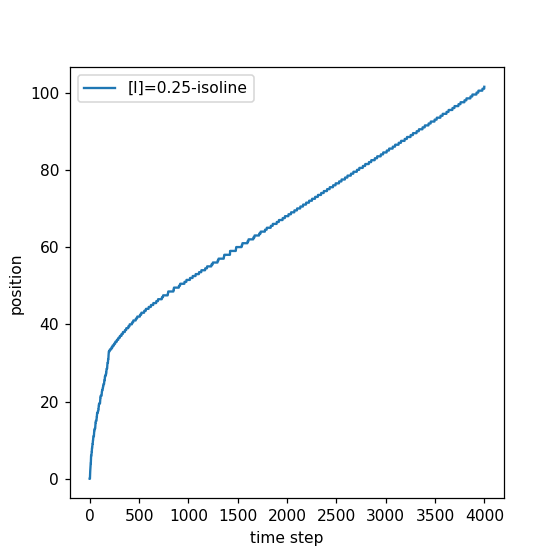

0.0165


In [7]:
fig, ax = plt.subplots(figsize=(5,5),dpi=140)
ax = plt.subplot(111)

ax.plot(vel_est_025,label='[I]=0.25-isoline')
plt.legend()
ax.set_ylabel('position')
ax.set_xlabel('time step')

vel = (vel_est_025[3000]-vel_est_025[2000])/1000
print(vel)

In [8]:
ki = 0#0.0003

T = 100#8000
n = int(T/dt)   

S1I,S2I = brd.get_initial_seed('seed_distorted.png',0.4,dx,nX,nY) # Vmax=0.4
S3 = np.zeros(np.shape(S1I))
I  = np.zeros(np.shape(S1I)) 
uni = np.ones(np.shape(S1I))
sol = 1*np.ones(np.shape(S1I))

sigma = 1
va,vb =1*vel, 1*vel # 15
SDV_a_0, SDV_b_0 = 35, 35
SDV_a_max, SDV_b_max = 165,165


for i in tqdm(range(n)):  
    SDV_a, SDV_b = SDV_a_0+i*va, SDV_b_0+i*vb
    if SDV_a >= SDV_a_max: SDV_a = SDV_a_max
    if SDV_b >= SDV_b_max: SDV_b = SDV_b_max      
    
    deltaS1I = Ds1i*brd.SDV_laplacian_expanding(S1I,r_r=SDV_a,c_r=SDV_b,dx=1) 
    deltaS2I = Ds2i*brd.SDV_laplacian_expanding(S2I,r_r=SDV_a,c_r=SDV_b,dx=1)
    deltaI   = Di*brd.SDV_laplacian_expanding(I,r_r=SDV_a,c_r=SDV_b,dx=1)

    S1I0 = S1I[1:-1,1:-1]
    S2I0 = S2I[1:-1,1:-1]
    S30  = S3[1:-1,1:-1]
    I0   = I[1:-1,1:-1]
    
    sol = brd.hill_func(C_cr=I_cr/100,lam=h,c=I/100)  
    #delta = np.random.uniform(low=-1, high=+1, size=(nX-2,nX-2))
    #sigma = 1*(1+delta)
   
    S1I[1:-1,1:-1], S2I[1:-1, 1:-1] = \
        S1I0 + dt * (sigma*deltaS1I + sol[1:-1,1:-1]*(-S1I0*S2I0**2) + f*(1-S1I0)),\
        S2I0 + dt * (sigma*deltaS2I + sol[1:-1,1:-1]*(S1I0*S2I0**2)  - k_sol*S2I0) 

    I[1:-1,1:-1]  =  I0 + dt * (sigma*deltaI + k_sol*S2I0-ki*I0)
    S3[1:-1,1:-1] =  S30 + dt * (k_sol*S2I0)
    
    if (i==1000)&(np.sum(1*(S2I>0.35))<20): break
        
#os.system('play -nq -t alsa synth {} sine {}'.format(0.5, 350))

  0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


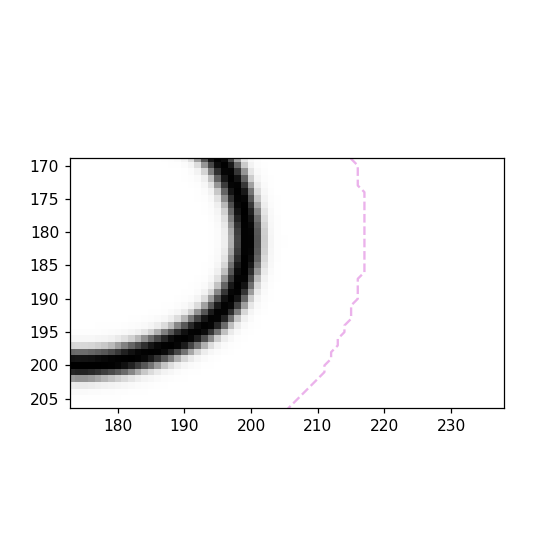

/home/epsilon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: No contour levels were found within the data range.
  # Remove the CWD from sys.path while we load stuff.


In [9]:
from skimage.draw import ellipse 

fig, ax = plt.subplots(figsize=(5,5),dpi=140)
ax = plt.subplot(111)

SDV_boundary = np.zeros((nY,nX))
rr, cc = ellipse(nY//2, nX//2, SDV_a, SDV_b)
SDV_boundary[rr, cc] = 1

ax.contour(SDV_boundary,levels=[0,1], colors=['m'],linewidths = 1.5, alpha=0.3,linestyles='dashed')
im = ax.imshow(S3,cmap='Greys')